### About
Multiclass classification on 102 types of flowers using the [Oxford Flowers 102 dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/).

#### Accuracy
- Mine: 0.969608
- SOTA: ?

### Setup
Load the fastai libraries.

In [1]:
from fastai import *
from fastai.vision import *

### Data
Download the dataset and look at the file structure.  All 3 files have labels.  I'm not sure why the majority of the data is given to the test set instead of training.  In the spirit of getting more training data I'm training on both the test and train datasets and using the valid dataset for validation.  Given the test set is labeled it's not really a test set.  Images vary in size but most are around 500x500.

In [2]:
untar_data(URLs.FLOWERS)

/usr/local/lib/python3.6/dist-packages/fastai/datasets.py:164: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  with open(fpath, 'r') as yaml_file: return yaml.load(yaml_file)


PosixPath('/root/.fastai/data/oxford-102-flowers')

In [3]:
path = Path('/root/.fastai/data/oxford-102-flowers')

In [4]:
def read_dataset(path):
    df = pd.read_csv(path, header=None, names=['path', 'label'], sep=' ')
    print(df.head())
    print(len(df))
    return df

In [5]:
train_df = read_dataset(path/'train.txt')

                  path  label
0  jpg/image_03860.jpg     16
1  jpg/image_06092.jpg     13
2  jpg/image_02400.jpg     42
3  jpg/image_02852.jpg     55
4  jpg/image_07710.jpg     96
1020


In [6]:
valid_df = read_dataset(path/'valid.txt')

                  path  label
0  jpg/image_04467.jpg     89
1  jpg/image_07129.jpg     44
2  jpg/image_05166.jpg      4
3  jpg/image_07002.jpg     34
4  jpg/image_02007.jpg     79
1020


In [7]:
test_df = read_dataset(path/'test.txt')

                  path  label
0  jpg/image_06977.jpg     34
1  jpg/image_00800.jpg     80
2  jpg/image_05038.jpg     58
3  jpg/image_06759.jpg      0
4  jpg/image_01133.jpg     45
6149


In [8]:
# need to concatenate dataframes for passing to fastai datablock API
training_df = pd.concat([test_df, train_df, valid_df])

In [9]:
# examine image sizes
xs = []
ys = []
for file in os.listdir(path/'jpg'):
    img = open_image(path/f'jpg/{file}')
    x, y = img.size
    xs.append(x)
    ys.append(y)

(array([6.318e+03, 1.050e+02, 1.080e+02, 9.400e+01, 8.100e+01, 8.700e+01, 7.200e+01, 8.500e+01, 7.000e+01, 1.250e+02,
        6.600e+01, 6.100e+01, 3.340e+02, 5.200e+01, 4.600e+01, 3.800e+01, 3.600e+01, 2.500e+01, 2.650e+02, 3.000e+01,
        1.700e+01, 1.300e+01, 1.100e+01, 7.000e+00, 7.000e+00, 6.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([ 500.  ,  513.36,  526.72,  540.08, ..., 1127.92, 1141.28, 1154.64, 1168.  ]),
 <a list of 50 Patch objects>)

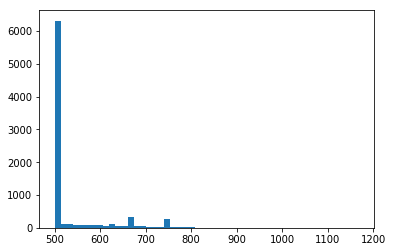

In [10]:
plt.hist(xs, bins=50)

(array([2.143e+03, 1.000e+02, 9.900e+01, 1.070e+02, 1.000e+02, 1.040e+02, 8.600e+01, 7.000e+01, 9.000e+01, 8.200e+01,
        8.400e+01, 1.870e+02, 1.520e+02, 9.700e+01, 1.130e+02, 2.045e+03, 2.570e+02, 1.020e+02, 1.320e+02, 1.480e+02,
        1.060e+02, 8.700e+01, 9.800e+01, 4.460e+02, 9.500e+02, 5.400e+01, 4.000e+01, 2.700e+01, 2.400e+01, 1.000e+01,
        1.400e+01, 1.200e+01, 7.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 500.  ,  510.48,  520.96,  531.44, ...,  992.56, 1003.04, 1013.52, 1024.  ]),
 <a list of 50 Patch objects>)

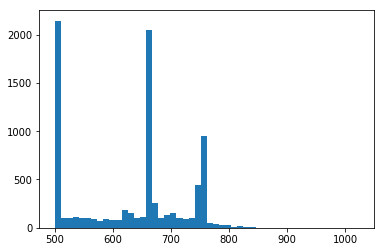

In [11]:
plt.hist(ys, bins=50)

### Model
Create the model.  Use a resnet pre-trained on imagenet.  Do all the affine and lighting transformation except for vertical flip.

In [12]:
bs = 64
num_workers = 8
size = 224
model = models.resnet34

In [13]:
tfms = get_transforms()

In [14]:
valid_start_idx = len(test_df) + len(train_df)
valid_end_idx = len(test_df) + len(train_df) + len(valid_df)

src = (ImageList.from_df(training_df, path)
       .split_by_idx(valid_idx=range(valid_start_idx, valid_end_idx))
       .label_from_df())

In [15]:
data = (src.transform(tfms, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

In [16]:
learn = cnn_learner(data, model, metrics=[accuracy])

In [17]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________

### Train
Run the learning rate finder and train the model using 1-cycle learning.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


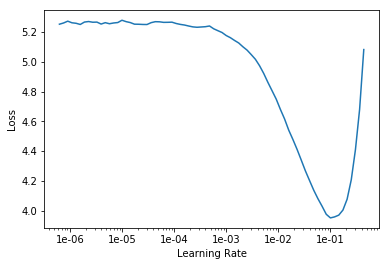

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(7, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.860424,0.583829,0.854902,00:39
1,0.856985,1.352047,0.673529,00:38
2,0.659464,0.653078,0.830392,00:40
3,0.408398,0.390974,0.894118,00:40
4,0.253999,0.178936,0.937255,00:39
5,0.133636,0.136315,0.959804,00:37
6,0.090721,0.138986,0.961765,00:35


In [20]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


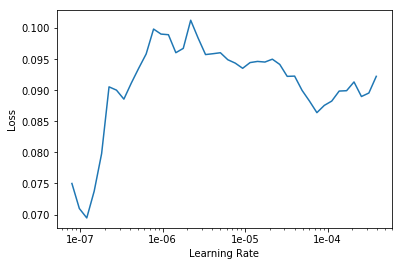

In [22]:
learn.lr_find(start_lr=1e-8)
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(5, max_lr=slice(4e-6, 4e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.078159,0.119905,0.968627,00:39
1,0.073607,0.120014,0.965686,00:36
2,0.066946,0.121539,0.966667,00:38
3,0.056075,0.114751,0.967647,00:39
4,0.053314,0.117197,0.969608,00:38


### Results
Dig into the results by plotting top losses with an attention heatmap.

In [25]:
preds, targs, losses = learn.get_preds(with_loss=True)

In [26]:
interp = ClassificationInterpretation(learn, preds, targs, losses)

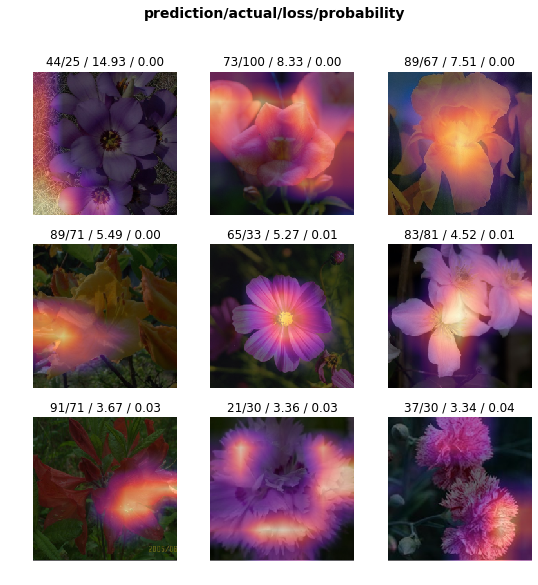

In [27]:
interp.plot_top_losses(9, figsize=(9, 9))

In [29]:
interp.most_confused()

[(3, 20, 1),
 (3, 31, 1),
 (18, 8, 1),
 (25, 44, 1),
 (30, 21, 1),
 (30, 37, 1),
 (30, 97, 1),
 (31, 29, 1),
 (33, 65, 1),
 (37, 91, 1),
 (41, 19, 1),
 (42, 82, 1),
 (44, 2, 1),
 (53, 40, 1),
 (66, 83, 1),
 (67, 89, 1),
 (68, 61, 1),
 (71, 89, 1),
 (71, 91, 1),
 (79, 19, 1),
 (81, 83, 1),
 (89, 42, 1),
 (89, 57, 1),
 (90, 89, 1),
 (91, 21, 1),
 (95, 96, 1),
 (96, 15, 1),
 (96, 95, 1),
 (97, 92, 1),
 (98, 23, 1),
 (100, 73, 1)]

In [30]:
# total number of incorrect predictions
int(torch.sum(interp.pred_class != interp.y_true))

31